Batch #1 MSE: 15.397


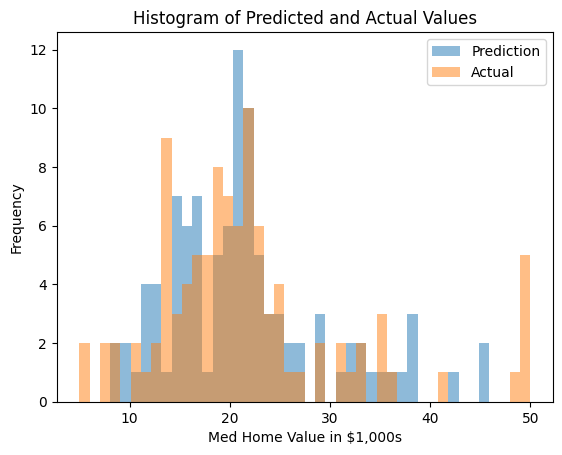

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
tf.compat.v1.disable_eager_execution()
# Load Housing Data
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)

housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x) >= 1] for y in housing_file.text.split('\n') if len(y) >= 1]

# Extract Features and Labels
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
x_vals = np.array([[x for i, x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

# Train-Test Split
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# TensorFlow Model
k = 4
batch_size = len(x_vals_test)

# Define Variables
batch_size_train = len(x_vals_train)
batch_size_test = len(x_vals_test)

x_data_train = tf.Variable(tf.zeros([batch_size_train, num_features], dtype=tf.float32))
x_data_test = tf.Variable(tf.zeros([batch_size_test, num_features], dtype=tf.float32))
y_target_train = tf.Variable(tf.zeros([batch_size_train, 1], dtype=tf.float32))
y_target_test = tf.Variable(tf.zeros([batch_size_test, 1], dtype=tf.float32))

# Calculate distances and predictions
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test, 1))), axis=2)
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)

x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, axis=1), 1)
x_sums_repeated = tf.matmul(x_sums, tf.ones([1, k], tf.float32))
x_val_weights = tf.expand_dims(tf.divide(top_k_xvals, x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_val_weights, top_k_yvals), axis=[1])

mse = tf.divide(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)

# Run TensorFlow Session
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_loops = int(np.ceil(len(x_vals_test) / batch_size))

    for i in range(num_loops):
        min_index = i * batch_size
        max_index = min((i + 1) * batch_size, len(x_vals_train))
        x_batch = x_vals_test[min_index:max_index]
        y_batch = y_vals_test[min_index:max_index]

        sess.run(tf.group(
            x_data_train.assign(x_vals_train),
            x_data_test.assign(x_batch),
            y_target_train.assign(y_vals_train),
            y_target_test.assign(y_batch)
        ))

        predictions_out, batch_mse = sess.run([prediction, mse])
        print('Batch #' + str(i + 1) + ' MSE: ' + str(np.round(batch_mse, 3)))
# Plotting Histograms
bins = np.linspace(5, 50, 45)
plt.hist(predictions_out, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()